In [1]:
%matplotlib inline

In [2]:
!git clone -b kitti_example https://github.com/HongLouyemeng/pypose.git

Cloning into 'pypose'...
remote: Enumerating objects: 7078, done.
remote: Counting objects: 100% (943/943), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 7078 (delta 806), reused 726 (delta 695), pack-reused 6135
Receiving objects: 100% (7078/7078), 7.55 MiB | 16.29 MiB/s, done.
Resolving deltas: 100% (4607/4607), done.


In [3]:
!pip install pykitti

In [4]:
%ls
%cd pypose/

pypose/  sample_data/
/content/pypose


In [5]:

import os
import argparse
import torch
import pykitti
import numpy as np
import pypose as pp
from pypose.module import EKF,UKF,PF
from datetime import datetime
import torch.utils.data as Data
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
from torchvision.datasets.utils import download_and_extract_archive
import matplotlib.ticker as mtick
import torch, os
import numpy as np
import pypose as pp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.legend_handler import HandlerLine2D

class KITTI_IMU(Data.Dataset):
    datalink = 'https://github.com/pypose/pypose/releases/download/v0.2.2/2011_09_26.zip'
    def __init__(self, root, dataname, drive, duration=10, step_size=1, mode='train', download=True):
        super().__init__()
        if download:
            download_and_extract_archive(self.datalink, root)
        self.duration = duration
        self.data = pykitti.raw(root, dataname, drive)
        self.seq_len = len(self.data.timestamps) - 1
        assert mode in ['evaluate', 'train',
                        'test'], "{} mode is not supported.".format(mode)
        self.gps = torch.tensor([[self.data.oxts[i].packet.lon,
                                   self.data.oxts[i].packet.lat,self.data.oxts[i].packet.alt]
                                   for i in range(self.seq_len)])
        self.input = torch.tensor([[self.data.oxts[i].packet.vf,self.data.oxts[i].packet.yaw]
                                   for i in range(self.seq_len)])

        self.dt = torch.tensor([datetime.timestamp(self.data.timestamps[i+1]) -
                               datetime.timestamp(self.data.timestamps[i])
                               for i in range(self.seq_len)])

        self.gyro = torch.tensor([[self.data.oxts[i].packet.wx,
                                   self.data.oxts[i].packet.wy,
                                   self.data.oxts[i].packet.wz]
                                   for i in range(self.seq_len)])

        self.acc = torch.tensor([[self.data.oxts[i].packet.ax,
                                  self.data.oxts[i].packet.ay,
                                  self.data.oxts[i].packet.az]
                                  for i in range(self.seq_len)])
        self.gt_rot = pp.euler2SO3(torch.tensor([[self.data.oxts[i].packet.roll,
                                                  self.data.oxts[i].packet.pitch,
                                                  self.data.oxts[i].packet.yaw]
                                                  for i in range(self.seq_len)]))
        self.gt_vel = self.gt_rot @ torch.tensor([[self.data.oxts[i].packet.vf,
                                                   self.data.oxts[i].packet.vl,
                                                   self.data.oxts[i].packet.vu]
                                                   for i in range(self.seq_len)])
        self.gt_pos = torch.tensor(
            np.array([self.data.oxts[i].T_w_imu[0:3, 3] for i in range(self.seq_len)]))

        start_frame = 0
        end_frame = self.seq_len
        if mode == 'train':
            end_frame = np.floor(self.seq_len * 0.5).astype(int)
        elif mode == 'test':
            start_frame = np.floor(self.seq_len * 0.5).astype(int)

        self.index_map = [i for i in range(
            0, end_frame - start_frame - self.duration, step_size)]

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, i):
        frame_id = self.index_map[i]

        end_frame_id = frame_id + self.duration
        return {
            'gps': self.gps[frame_id: end_frame_id],
            'input': self.input[frame_id: end_frame_id],
            'dt': self.dt[frame_id: end_frame_id],
            'acc': self.acc[frame_id: end_frame_id],
            'gyro': self.gyro[frame_id: end_frame_id],
            'gyro': self.gyro[frame_id: end_frame_id],
            'gt_pos': self.gt_pos[frame_id+1: end_frame_id+1],
            'gt_rot': self.gt_rot[frame_id+1: end_frame_id+1],
            'gt_vel': self.gt_vel[frame_id+1: end_frame_id+1],
            'init_pos': self.gt_pos[frame_id][None, ...],
            # TODO: the init rotation might be used in gravity compensation
            'init_rot': self.gt_rot[frame_id: end_frame_id],
            'init_vel': self.gt_vel[frame_id][None, ...],
        }

    def get_init_value(self):
        return {'pos': self.gt_pos[:1],
                'rot': self.gt_rot[:1],
                'vel': self.gt_vel[:1],
                'input': self.input[:1],
                'gps': self.gps}
def imu_collate(data):
    gps = torch.stack([d['gps'] for d in data])
    input = torch.stack([d['input'] for d in data])
    acc = torch.stack([d['acc'] for d in data])
    gyro = torch.stack([d['gyro'] for d in data])

    gt_pos = torch.stack([d['gt_pos'] for d in data])
    gt_rot = torch.stack([d['gt_rot'] for d in data])
    gt_vel = torch.stack([d['gt_vel'] for d in data])

    init_pos = torch.stack([d['init_pos'] for d in data])
    init_rot = torch.stack([d['init_rot'] for d in data])
    init_vel = torch.stack([d['init_vel'] for d in data])

    dt = torch.stack([d['dt'] for d in data]).unsqueeze(-1)

    return {
        'dt': dt,
        'gps': gps,
        'input': input,
        'acc': acc,
        'gyro': gyro,

        'gt_pos': gt_pos,
        'gt_vel': gt_vel,
        'gt_rot': gt_rot,

        'init_pos': init_pos,
        'init_vel': init_vel,
        'init_rot': init_rot,
    }
def move_to(obj, device):
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        res = {}
        for k, v in obj.items():
            res[k] = move_to(v, device)
        return res
    elif isinstance(obj, list):
        res = []
        for v in obj:
            res.append(move_to(v, device))
        return res
    else:
        raise TypeError("Invalid type for move_to", obj)
def plot_gaussian(ax, means, covs, color=None, sigma=3):
    ''' Set specific color to show edges, otherwise same with facecolor.'''
    ellipses = []
    for i in range(len(means)):
        eigvals, eigvecs = np.linalg.eig(covs[i])
        axis = np.sqrt(eigvals) * sigma
        slope = eigvecs[1][0] / eigvecs[1][1]
        angle = 180.0 * np.arctan(slope) / np.pi
        ellipses.append(Ellipse(means[i, 0:2], axis[0], axis[1], angle=angle))
    ax.add_collection(PatchCollection(ellipses, edgecolors=color, linewidth=1))

class Car(pp.module.NLS):

    def __init__(self):
        super().__init__()

    def state_transition(self, state, input, t=None):
        '''
        Don't add noise in this function, as it will be used for automatically
        linearizing the system by the parent class ``pp.module.NLS``.
        https://speakerdeck.com/motokimura/shi-jian-karumanhuiruta
        '''
        r = input[0] /  input[1]
        dtheta = input[1]*t
        x = state[..., 0] - r * state[..., 2].sin() + r * (state[..., 2] + dtheta).sin()
        y = state[..., 1] + r * state[..., 2].cos() - r * (state[..., 2] + dtheta).cos()
        theta = state[..., 2] + dtheta

        # theta = state[..., 2] + input[1]
        # x = state[..., 0] + input[..., 0] * theta.cos()
        # y = state[..., 1] + input[..., 0] * theta.sin()
        return torch.stack([x, y, theta], dim=-1)

    def observation(self, state, input, t=None):
        '''
        Don't add noise in this function, as it will be used for automatically
        linearizing the system by the parent class ``pp.module.NLS``.
        '''
        return  state
        # r = input[0] / input[1]
        # dtheta = input[1] * t
        # x = state[..., 0] - r * state[..., 2].sin() + r * (state[..., 2] + dtheta).sin()
        # y = state[..., 1] + r * state[..., 2].cos() - r * (state[..., 2] + dtheta).cos()
        # theta = state[..., 2] + dtheta
        #
        # # theta = state[..., 2] + input[1]
        # # x = state[..., 0] + input[..., 0] * theta.cos()
        # # y = state[..., 1] + input[..., 0] * theta.sin()
        # return torch.stack([x, y, theta], dim=-1)
def bicycle_plot(model_name, state, est, cov, save=None, show=True):
    N = state.shape[0]
    state = state.cpu().numpy()
    est = est.cpu().numpy()
    cov = cov.cpu().numpy()
    w = torch.arange(0, N, dtype=torch.float).view(-1, 1) / N
    c = torch.tensor([[1, 0, 0, 1]]).repeat(N, 1) * w + \
        torch.tensor([[0, 0, 1, 1]]).repeat(N, 1) * (1 - w)
    color = c.tolist()
    fig, ax = plt.subplots()
    for i in range(N):
        eigvals, eigvecs = np.linalg.eig(cov[i])
        axis = np.sqrt(eigvals) * 3
        slope = eigvecs[1][0] / eigvecs[1][1]
        angle = 180.0 * np.arctan(slope) / np.pi
        e = Ellipse(est[i, 0:2], axis[0], axis[1], angle=angle)
        ax.add_artist(e)
        e.set_facecolor("none")
        e.set_edgecolor(color[i])
    state_plot = ax.quiver(state[:-1, 0], state[:-1, 1],
                           state[1:, 0] - state[:-1, 0], state[1:, 1] - state[:-1, 1],
                           scale_units="xy", angles="xy", scale=1, color=color,
                           label="True State")
    est_plot, = ax.plot(est[:, 0], est[:, 1], '.-', label="Estimated State")
    ax.legend(handler_map={est_plot: HandlerLine2D(numpoints=1)})
    plt.title("%s Example" % model_name.upper())

    if save is not None:
        figure = os.path.join(save, model_name + '_bicycle.png')
        plt.savefig(figure)
        print("Saved to", figure)

    if show:
        plt.show()
parser = argparse.ArgumentParser(description='IMU Preintegration')
parser.add_argument("--device",
                    type=str,
                    default='cpu',
                    help="cuda or cpu")
parser.add_argument("--batch-size",
                    type=int,
                    default=1,
                    help="batch size, only support 1 now") #why?
parser.add_argument("--step-size",
                    type=int,
                    default=1,
                    help="the size of the integration for one interval")
parser.add_argument("--save",
                    type=str,
                    default='dataset/save/',
                    help="location of png files to save")
parser.add_argument("--dataroot",
                    type=str,
                    default='dataset/',
                    help="dataset location downloaded")
parser.add_argument("--dataname",
                    type=str,
                    default='2011_09_26',
                    help="dataset name")
parser.add_argument("--datadrive",
                    nargs='+',
                    type=str,
                    default=["0001", "0002", "0005", "0009", "0011",
                             "0013", "0014", "0015", "0017", "0018",
                             "0019", "0020", "0022"],
                    help="data sequences")
parser.add_argument('--plot3d',
                    dest='plot3d',
                    action='store_true',
                    help="plot in 3D space, default: False")
parser.set_defaults(plot3d=False)
args, unknown = parser.parse_known_args()
print(args)
os.makedirs(os.path.join(args.save), exist_ok=True)
torch.set_default_tensor_type(torch.DoubleTensor)

Namespace(device='cpu', batch_size=1, step_size=1, save='dataset/save/', dataroot='dataset/', dataname='2011_09_26', datadrive=['0001', '0002', '0005', '0009', '0011', '0013', '0014', '0015', '0017', '0018', '0019', '0020', '0022'], plot3d=False)


Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


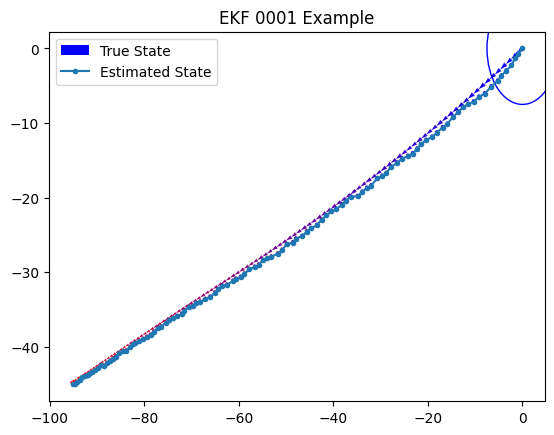

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


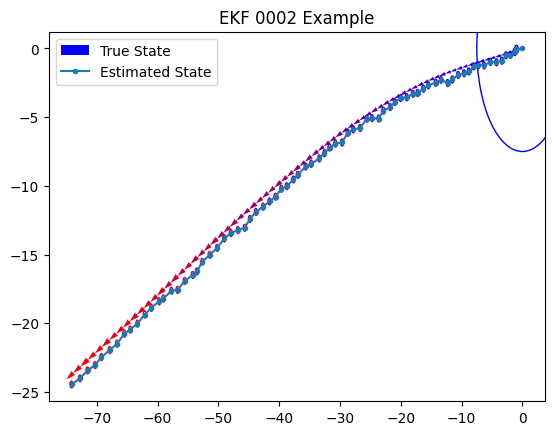

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


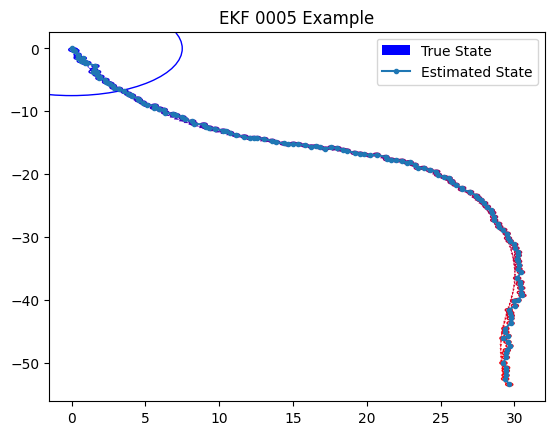

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


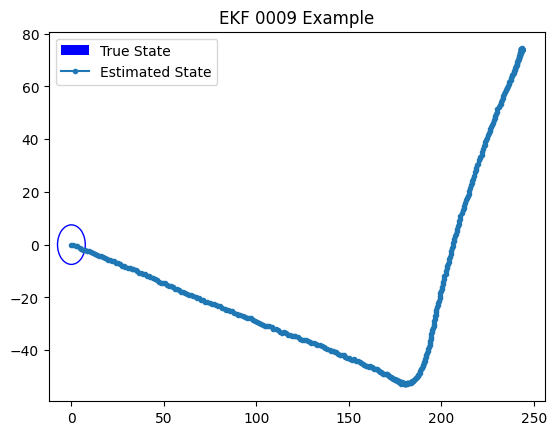

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


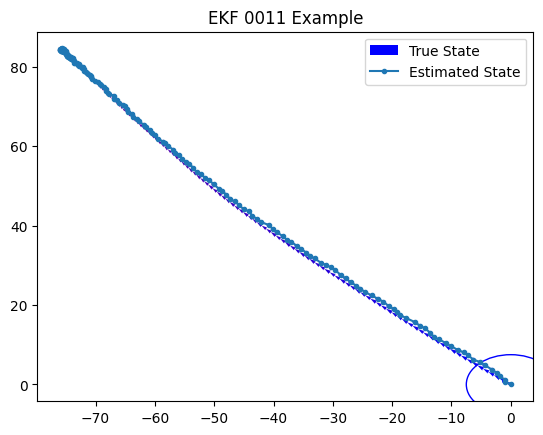

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


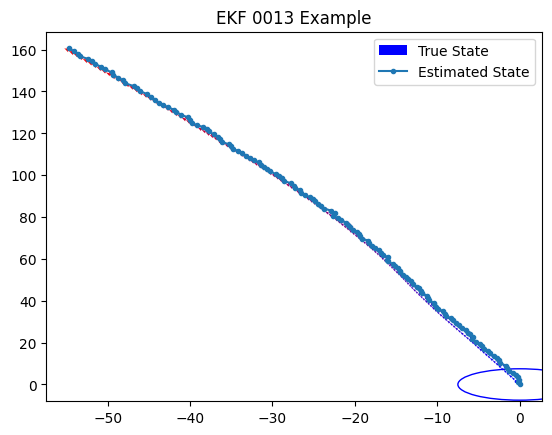

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


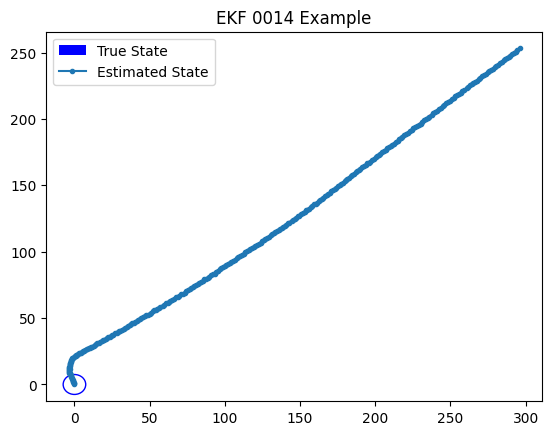

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


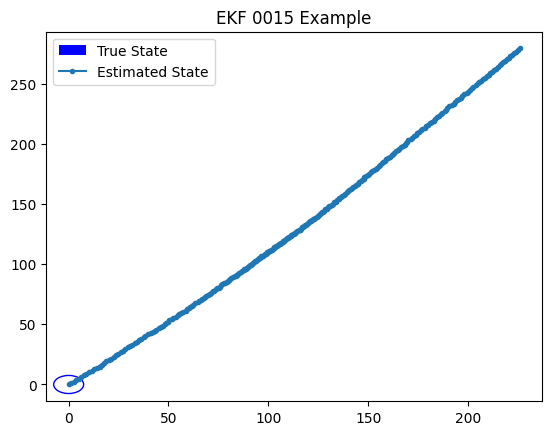

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


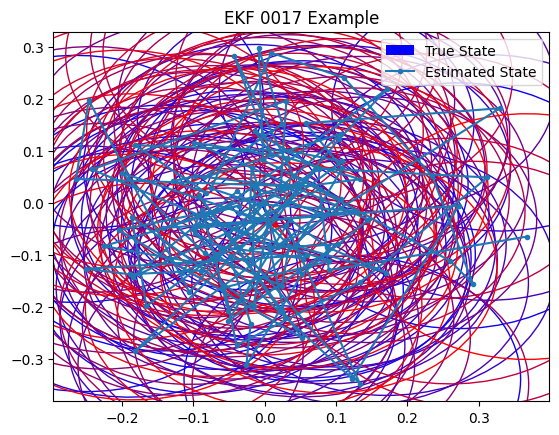

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


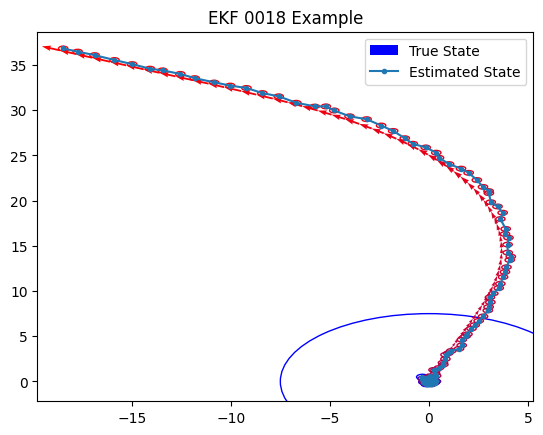

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


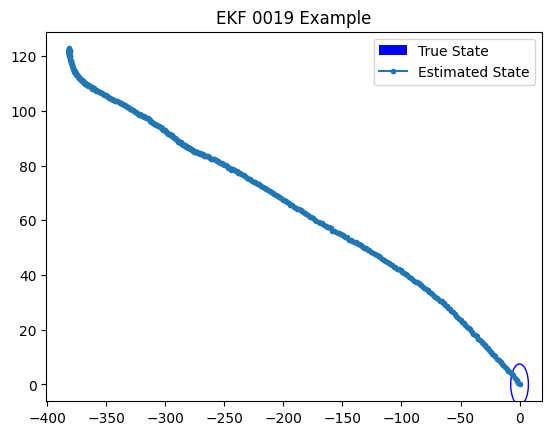

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


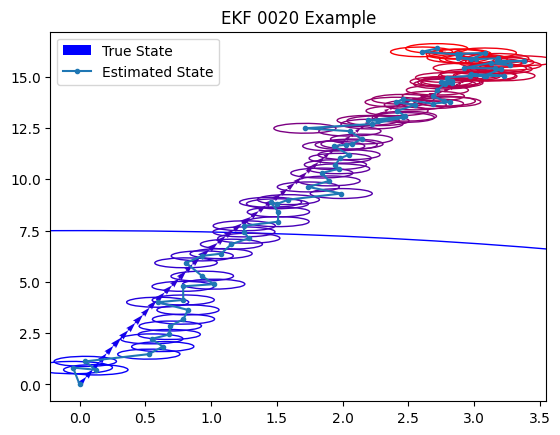

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


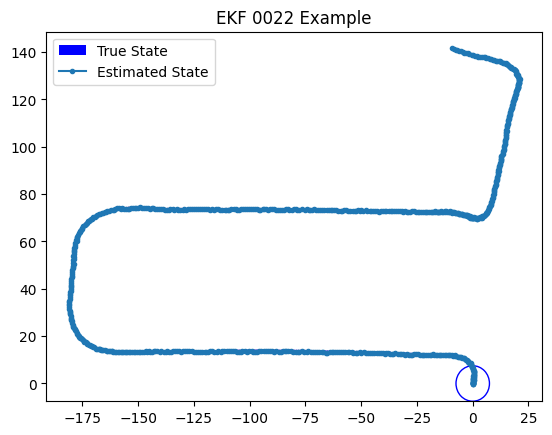

In [48]:
#EKF RESULT
N=3
error_ekf = []
for drive in args.datadrive:

    # Step 1: Define dataloader using the ``KITTI_IMU`` class we defined above
    dataset = KITTI_IMU(args.dataroot,
                        args.dataname,
                        drive,
                        duration=args.step_size,
                        step_size=args.step_size,
                        mode='evaluate')
    loader = Data.DataLoader(dataset=dataset,
                             batch_size=args.batch_size,
                             collate_fn=imu_collate,
                             shuffle=False)
    # Step 2: Get the initial position, rotation and velocity, all 0 here
    init = dataset.get_init_value()
    poses, poses_gt = [init['pos']], [init['pos']]
    T = len(loader)
    q, r, p = 0.2, 0.2, 5
    P = torch.eye(N, device=args.device).repeat( len(loader), 1, 1) * p ** 2  # estimation covariance
    Q = torch.eye(N, device=args.device) * q ** 2  # covariance of transition
    R = torch.eye(N, device=args.device) * r ** 2  # covariance of observation
    est = torch.randn(T, N, device=args.device) * p
    obs = torch.zeros(T, N, device=args.device)
    state_ = torch.zeros(T, N, device=args.device)  # true states
    car = Car()
    filter = EKF(car, Q, R).to(args.device)
    poses, poses_gt = [init['pos']], [init['pos']]
    est[0] = init['pos'].reshape(-1,N)
    for i, data in enumerate(loader):
        if i == T-1:
          break
        w = q * torch.randn(N, device=args.device)
        v = r * torch.randn(N, device=args.device)
        data = move_to(data, args.device)
        dt = data['dt']
        states = data['gt_pos'].reshape(-1,N)
        input = data['input'].reshape(-1)
        poses_gt.append(data['gt_pos'][..., -1, :].cpu())
        state_[i + 1], obs[i] = car(states , input)  # model measurement
        est[i + 1], P[i + 1] = filter(est[i], obs[i] + v , input, P[i],t = dt)

    poses_gt = torch.cat(poses_gt)
    state_ = state_.numpy()
    mse = torch.nn.MSELoss()
    error = torch.sqrt(mse(est,poses_gt)).numpy().reshape(1)[0]
    error_ekf.append(error)
    bicycle_plot('EKF %s'%drive, poses_gt, est, P)
    # poses_gt = torch.cat(poses_gt).numpy()
    # state_ = state_.numpy()
    # fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    # ax.plot(est[:,0],est[:,1])
    # ax.plot(poses_gt[:,0],poses_gt[:,1])
    # plt.title("PyPose EKF %s"%drive)
    # plt.legend(["PyPose", "Ground Truth"])
    # ax.set_xlabel('X [m]')
    # ax.set_ylabel('Y [m]')
    # ax.grid();
    # plt.show()

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


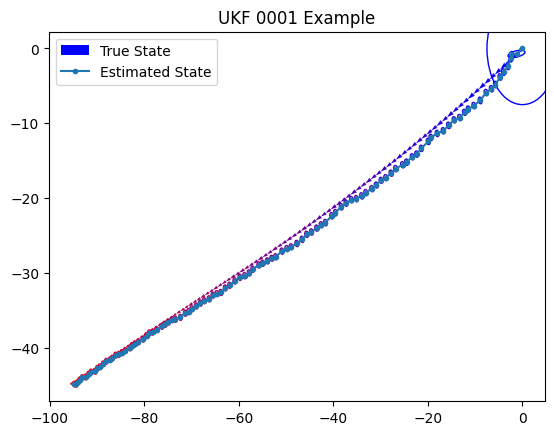

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


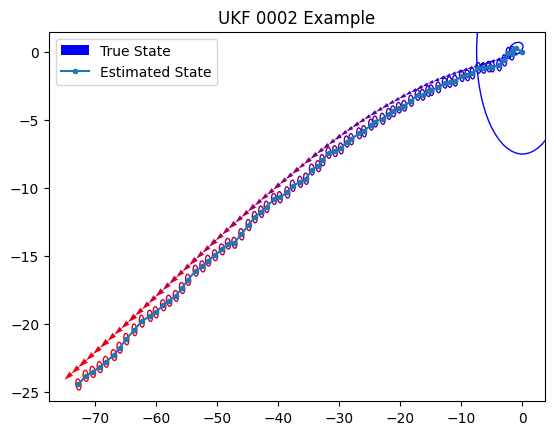

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


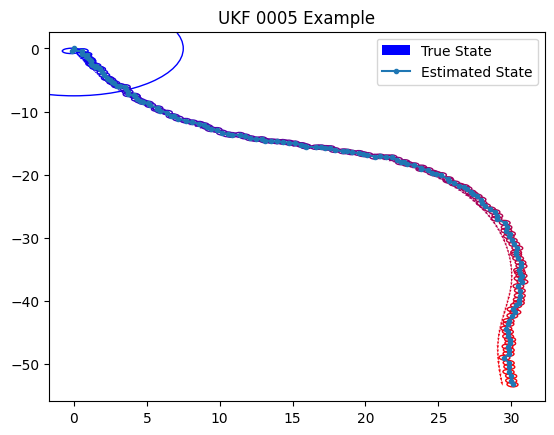

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


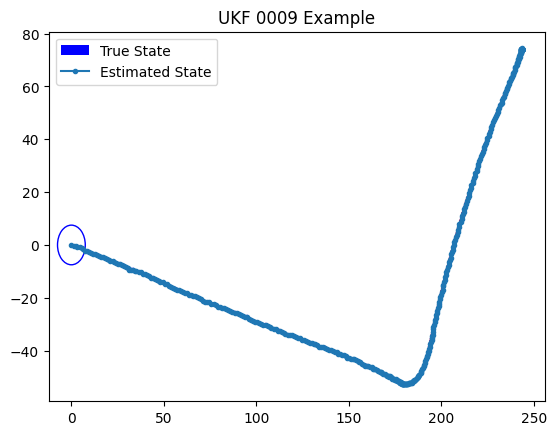

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


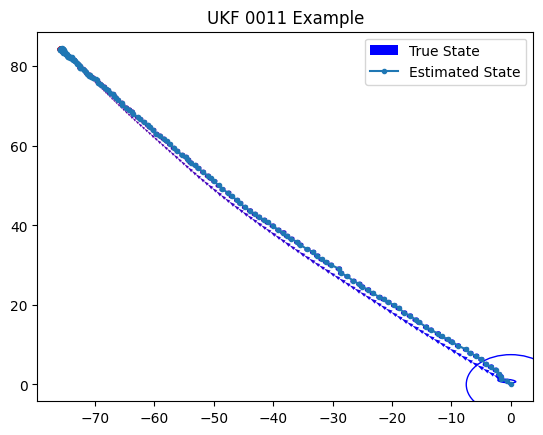

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


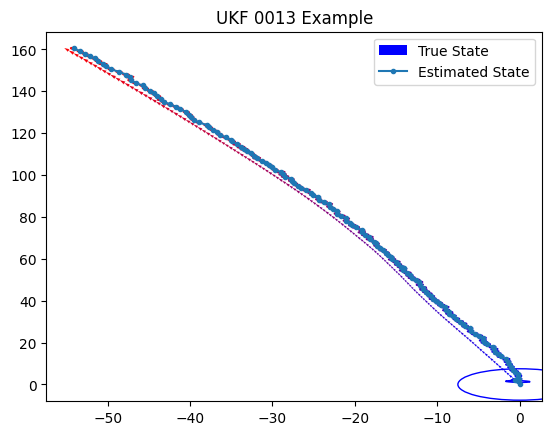

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


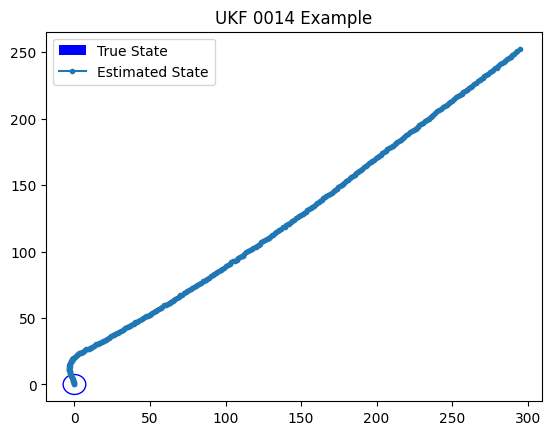

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


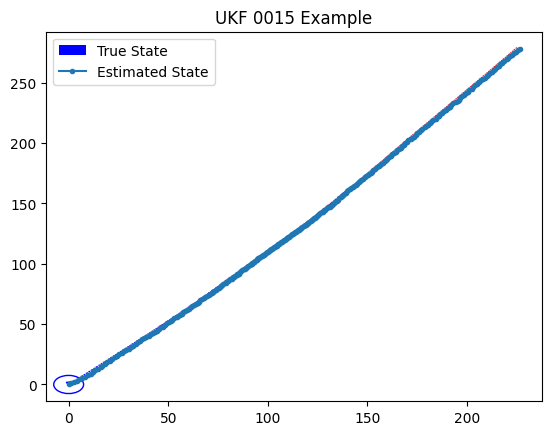

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


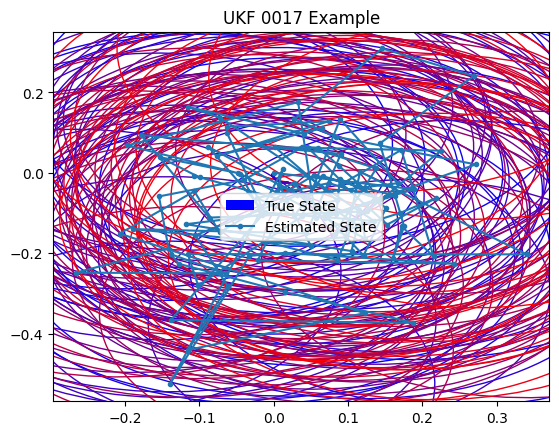

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


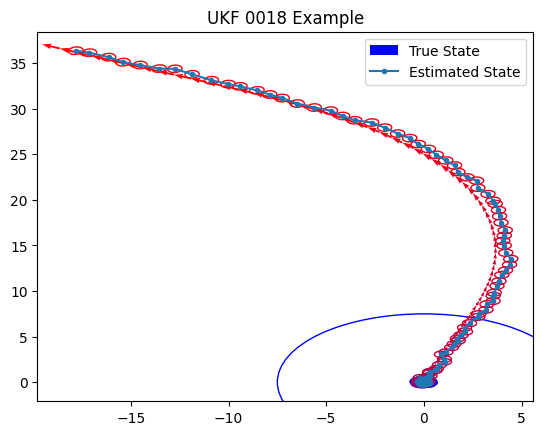

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


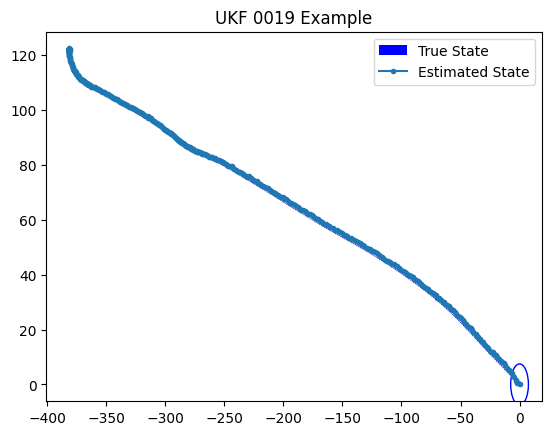

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


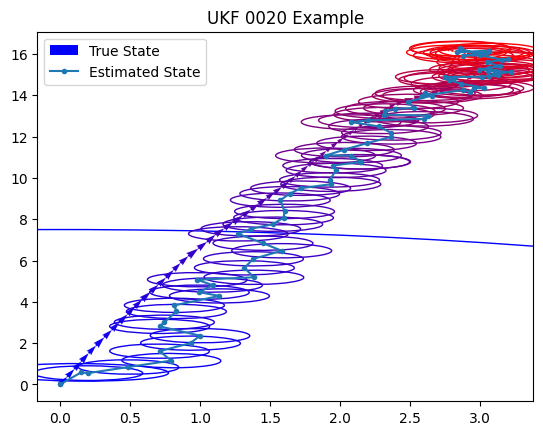

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


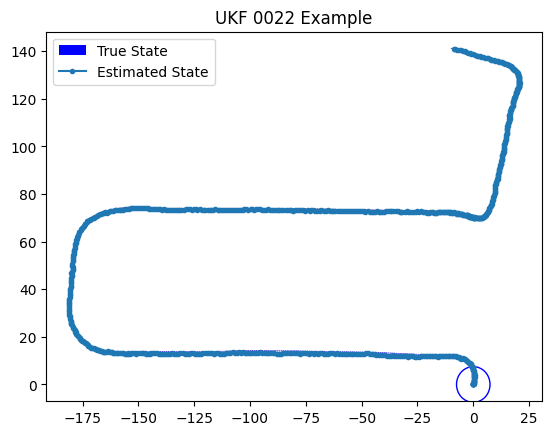

In [49]:
#UKF RESULT
N=3
error_ukf = []
for drive in args.datadrive:

    # Step 1: Define dataloader using the ``KITTI_IMU`` class we defined above
    dataset = KITTI_IMU(args.dataroot,
                        args.dataname,
                        drive,
                        duration=args.step_size,
                        step_size=args.step_size,
                        mode='evaluate')
    loader = Data.DataLoader(dataset=dataset,
                             batch_size=args.batch_size,
                             collate_fn=imu_collate,
                             shuffle=False)
    # Step 2: Get the initial position, rotation and velocity, all 0 here
    init = dataset.get_init_value()
    T = len(loader)
    q, r, p = 0.2, 0.2, 5
    P = torch.eye(N, device=args.device).repeat( len(loader), 1, 1) * p ** 2  # estimation covariance
    Q = torch.eye(N, device=args.device) * q ** 2  # covariance of transition
    R = torch.eye(N, device=args.device) * r ** 2  # covariance of observation
    est = torch.randn(T, N, device=args.device) * p
    obs = torch.zeros(T, N, device=args.device)
    state_ = torch.zeros(T, N, device=args.device)  # true states
    car = Car()
    filter = UKF(car, Q, R).to(args.device)
    poses_gt = [init['pos']]
    est[0] = init['pos'].reshape(-1,N)
    for i, data in enumerate(loader):
        if i == T-1:
          break
        w = q * torch.randn(N, device=args.device)
        v = r * torch.randn(N, device=args.device)
        data = move_to(data, args.device)
        dt = data['dt']
        states = data['gt_pos'].reshape(-1,N)
        input = data['input'].reshape(-1)
        poses_gt.append(data['gt_pos'][..., -1, :].cpu())
        state_[i + 1], obs[i] = car(states , input)  # model measurement
        est[i + 1], P[i + 1] = filter(est[i], obs[i] + v , input, P[i],t = dt)
    poses_gt = torch.cat(poses_gt)
    state_ = state_.numpy()
    mse = torch.nn.MSELoss()
    error = torch.sqrt(mse(est,poses_gt)).numpy().reshape(1)[0]
    error_ukf.append(error)
    bicycle_plot('UKF %s'%drive, poses_gt, est, P)
    plt.show()

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


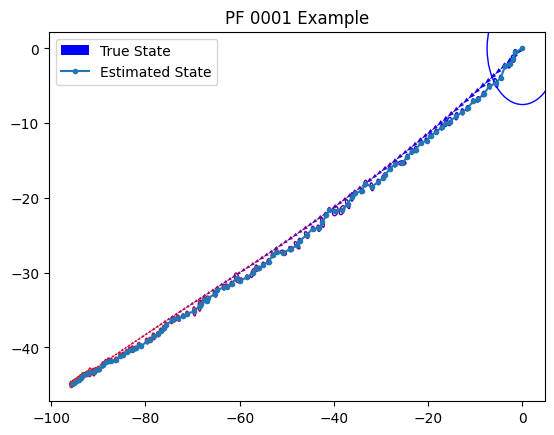

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


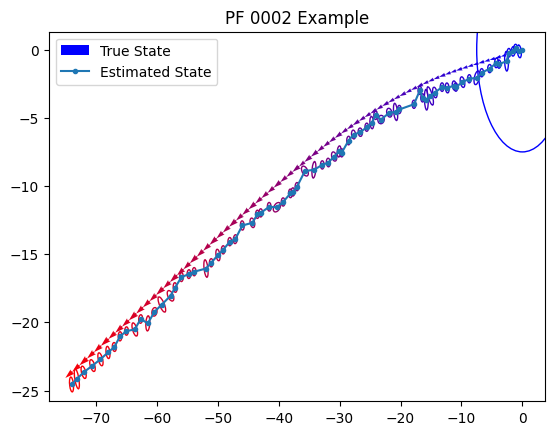

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


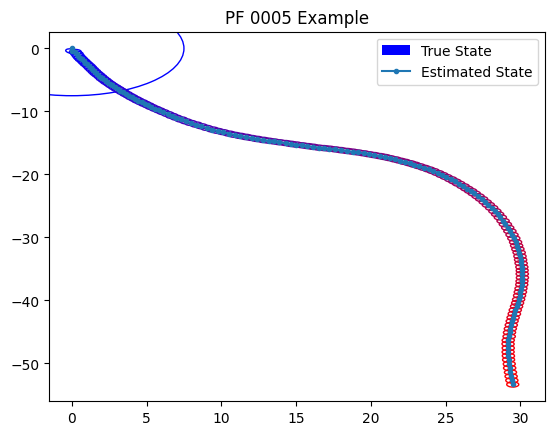

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


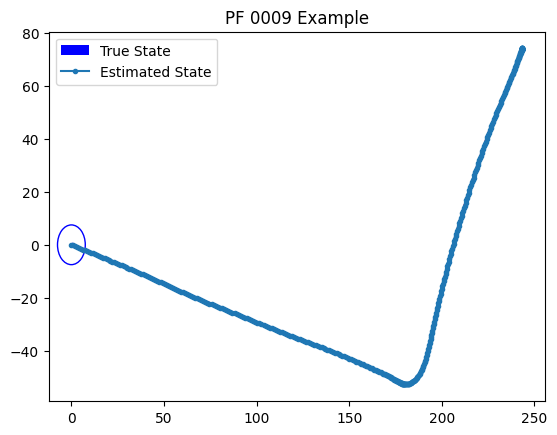

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


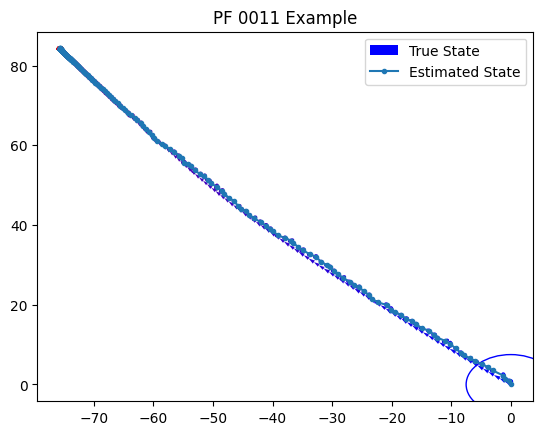

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


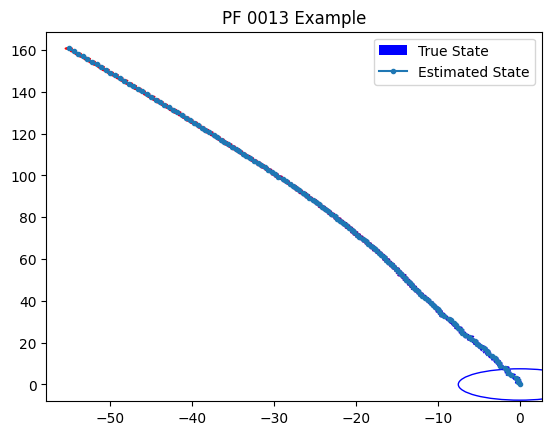

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


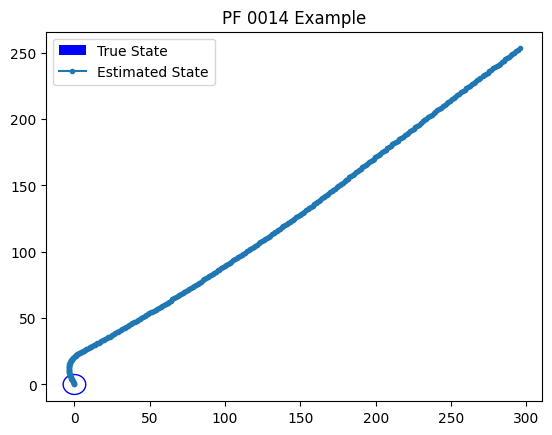

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


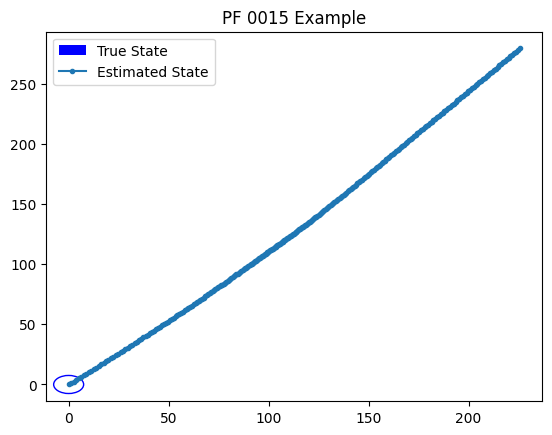

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


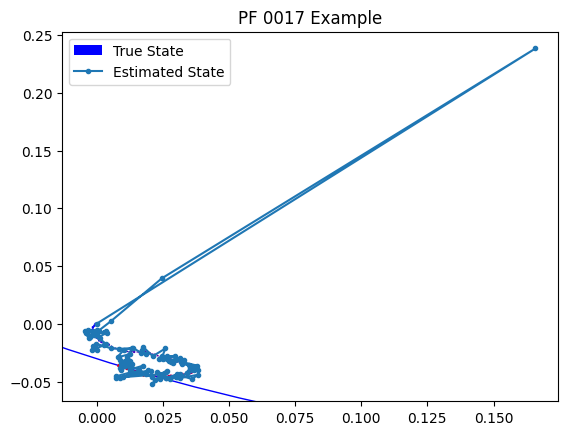

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


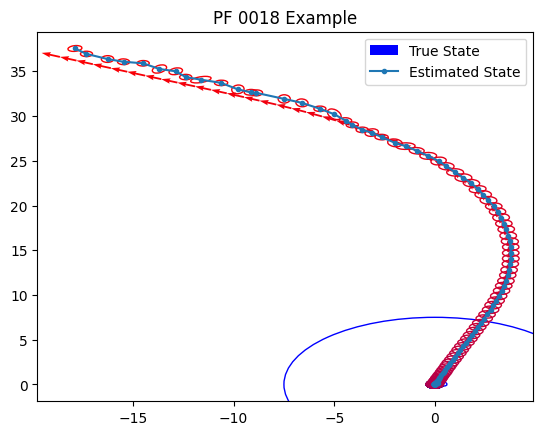

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


<ipython-input-5-d2bdf6414983>:210: RuntimeWarning: invalid value encountered in double_scalars
  slope = eigvecs[1][0] / eigvecs[1][1]
/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:2060: ComplexWarning: Casting complex values to real discards the imaginary part
  self._mtx[0, 0] *= sx
/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:2061: ComplexWarning: Casting complex values to real discards the imaginary part
  self._mtx[0, 1] *= sx
/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:2062: ComplexWarning: Casting complex values to real discards the imaginary part
  self._mtx[0, 2] *= sx
/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:2063: ComplexWarning: Casting complex values to real discards the imaginary part
  self._mtx[1, 0] *= sy
/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:2064: ComplexWarning: Casting complex values to real discards the imaginary part
  self._mtx[1, 1] *= sy
/usr/local/lib

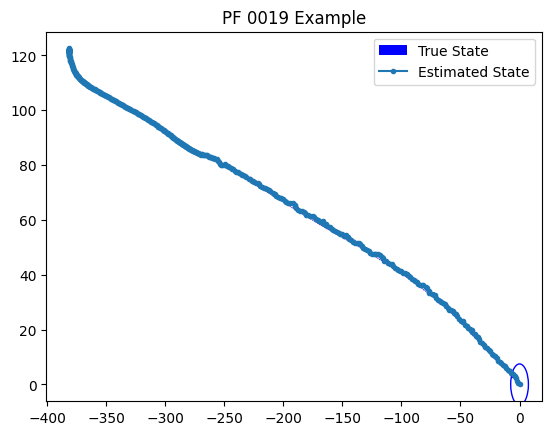

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


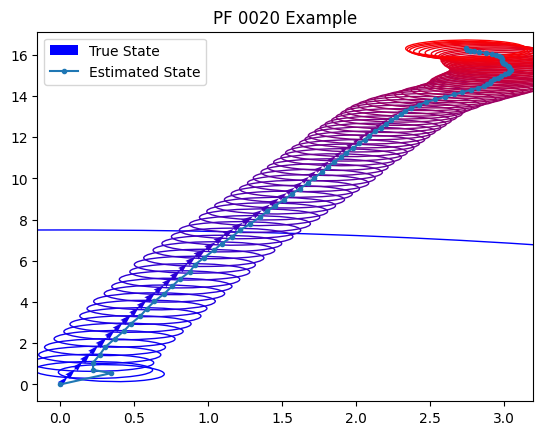

Using downloaded and verified file: dataset/2011_09_26.zip
Extracting dataset/2011_09_26.zip to dataset/


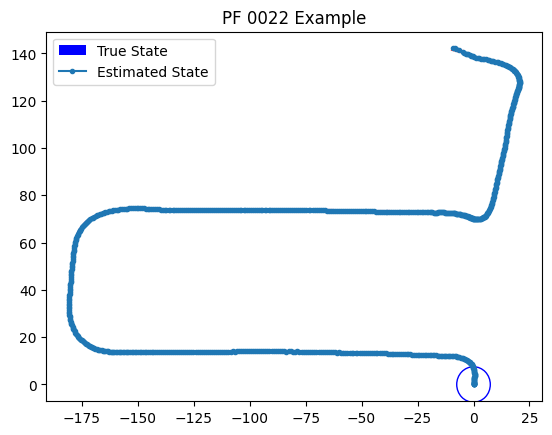

In [50]:
#PF RESULT
N=3
error_pf = []
for drive in args.datadrive:

    # Step 1: Define dataloader using the ``KITTI_IMU`` class we defined above
    dataset = KITTI_IMU(args.dataroot,
                        args.dataname,
                        drive,
                        duration=args.step_size,
                        step_size=args.step_size,
                        mode='evaluate')
    loader = Data.DataLoader(dataset=dataset,
                             batch_size=args.batch_size,
                             collate_fn=imu_collate,
                             shuffle=False)
    # Step 2: Get the initial position, rotation and velocity, all 0 here
    init = dataset.get_init_value()
    poses, poses_gt = [init['pos']], [init['pos']]
    T = len(loader)
    q, r, p = 0.2, 0.2,  5
    P = torch.eye(N, device=args.device).repeat( len(loader), 1, 1) * p ** 2  # estimation covariance
    Q = torch.eye(N, device=args.device) * q ** 2  # covariance of transition
    R = torch.eye(N, device=args.device) * r ** 2  # covariance of observation
    est = torch.randn(T, N, device=args.device) * p
    obs = torch.zeros(T, N, device=args.device)
    state_ = torch.zeros(T, N, device=args.device)  # true states
    car = Car()
    filter = PF(car, Q, R,particles=20000).to(args.device)
    poses, poses_gt = [init['pos']], [init['pos']]
    est[0] = init['pos'].reshape(-1,N)
    for i, data in enumerate(loader):
        if i == T-1:
          break
        data = move_to(data, args.device)
        dt = data['dt']
        states = data['gt_pos'].reshape(-1,N)
        input = data['input'].reshape(-1)
        poses_gt.append(data['gt_pos'][..., -1, :].cpu())
        state_[i + 1], obs[i] = car(states, input)  # model measurement
        est[i + 1], P[i + 1] = filter(est[i], obs[i], input, P[i],t = dt)
    poses_gt = torch.cat(poses_gt)
    state_ = state_.numpy()
    mse = torch.nn.MSELoss()
    error = torch.sqrt(mse(est,poses_gt)).numpy().reshape(1)[0]
    error_pf.append(error)
    bicycle_plot('PF %s'%drive, poses_gt, est, P)
    # fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    # ax.plot(est[:,0],est[:,1])
    # ax.plot(poses_gt[:,0],poses_gt[:,1])
    # plot_gaussian(ax, poses[:, 0:2], P)
    # plt.title("PyPose PF %s"%drive)
    # plt.legend(["PyPose", "Ground Truth"])
    # ax.set_xlabel('X [m]')
    # ax.set_ylabel('Y [m]')
    # ax.grid();
    # plt.show()

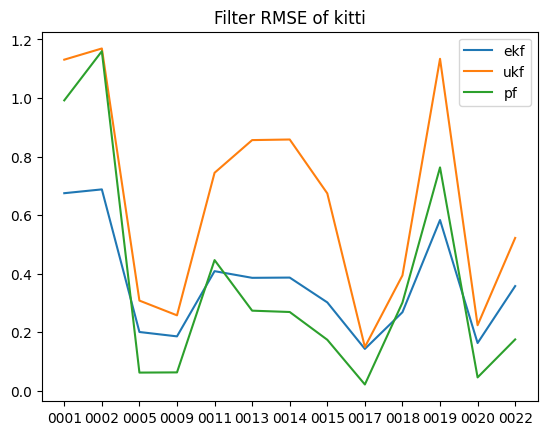

In [51]:
plt.plot(error_ekf)
plt.plot(error_ukf)
plt.plot(error_pf)
plt.legend(['ekf','ukf','pf'])
plt.title('Filter RMSE of kitti')
plt.xticks(range(len(error_ekf)),args.datadrive)
plt.show()

In [56]:
import pandas as pd
df = pd.DataFrame()
df['task'] = args.datadrive
df['error_ekf'] = error_ekf
df['error_ukf'] = error_ukf
df['error_pf'] = error_pf
df

,task,error_ekf,error_ukf,error_pf
0,0001,0.675030,1.131104,0.992064
1,0002,0.688053,1.169309,1.159869
2,0005,0.201008,0.308284,0.062342
3,0009,0.186060,0.257933,0.063038
4,0011,0.408759,0.744746,0.446536
5,0013,0.385997,0.856399,0.273843
6,0014,0.386841,0.858441,0.269293
7,0015,0.302091,0.674360,0.174426
8,0017,0.143265,0.149599,0.021757
9,0018,0.268588,0.394254,0.301393


import numpy as np
from google.colab import autoviz
df_6556443494615328561 = autoviz.get_df('df_6556443494615328561')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_6556443494615328561, *['error_ekf'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1687467135440550003 = autoviz.get_df('df_1687467135440550003')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_1687467135440550003, *['error_ukf'], **{})
chart

import numpy as np
from google.colab import autoviz
df_551194817027610493 = autoviz.get_df('df_551194817027610493')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_551194817027610493, *['error_pf'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6797693650503467080 = autoviz.get_df('df_6797693650503467080')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_6797693650503467080, *['error_ekf'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7433233435215981089 = autoviz.get_df('df_7433233435215981089')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_7433233435215981089, *['error_ukf'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6633741621990530427 = autoviz.get_df('df_6633741621990530427')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_6633741621990530427, *['error_pf'], **{})
chart

import numpy as np
from google.colab import autoviz
df_612578539196499967 = autoviz.get_df('df_612578539196499967')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_612578539196499967, *[[['error_ekf', 'error_ukf'], ['error_ukf', 'error_pf']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_5160001884216653263 = autoviz.get_df('df_5160001884216653263')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_5160001884216653263, *['error_ekf'], **{})
chart

import numpy as np
from google.colab import autoviz
df_5210786579017450168 = autoviz.get_df('df_5210786579017450168')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_5210786579017450168, *['error_ukf'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4141025384539678204 = autoviz.get_df('df_4141025384539678204')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_4141025384539678204, *['error_pf'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6783297557345611123 = autoviz.get_df('df_6783297557345611123')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_6783297557345611123, *['error_ekf'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4233671992250005839 = autoviz.get_df('df_4233671992250005839')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_4233671992250005839, *['error_ukf'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4427171147766569273 = autoviz.get_df('df_4427171147766569273')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_4427171147766569273, *['error_pf'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1272994266265695534 = autoviz.get_df('df_1272994266265695534')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_1272994266265695534, *[[['error_ekf', 'error_ukf'], ['error_ukf', 'error_pf']]], **{})
chart

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
